# UGM-Based Segmentation Pipeline for Addis Ababa, Ethiopia

# Retrieve the Satellite Image

In [9]:
import ee
import folium
import geemap
ee.Authenticate()
# ee.Initialize()
# # Define region: 10 km buffer around center
# center = ee.Geometry.Point(38.74, 9.03)
# region = center.buffer(10000)
# # Load and filter Sentinel-2
# s2 = ee.ImageCollection("COPERNICUS/S2_SR") \
#        .filterDate('2024-05-01','2024-05-10') \
#        .filterBounds(region) \
#        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
# image_s2 = s2.median().clip(region)
# # Load DEM (GMTED2010)
# dem = ee.Image("USGS/GMTED2010_FULL").select('min').clip(region)
# Initialize Earth Engine
import ee
import ee
# ee.Authenticate(scopes=[
#     'https://www.googleapis.com/auth/earthengine',
#     'https://www.googleapis.com/auth/devstorage.read_write',
#     'https://www.googleapis.com/auth/drive'
# ])


ee.Initialize(project="1032447484931")


# Define the center coordinates of the location and specify the radius (10000 ft = ~3048 meters)
center = [9.03, 38.74]  # Latitude, Longitude of Addis Ababa
radius = 304.8  # ~10,000 feet (in meters)
# center = [12.6, 37.47]  # [Latitude, Longitude] of Gondar
# radius = 304.8  # ~10,000 feet

# Create a bounding box geometry
geometry = ee.Geometry.Point(center[1], center[0]).buffer(radius)

# Define the image collection for Sentinel-2, with cloud cover aa
collection = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(geometry) \
    .filterDate('2025-04-01', '2025-04-10')  \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))  # Filter for low cloud cover

# Check collection size before attempting to get the first image
collection_size = collection.size().getInfo()

if collection_size > 0:
    # Get the first image from the collection (if any)
    try:
        image = ee.Image(collection.first())
        # Print image ID for reference
        print("Image ID:", image.id().getInfo())

        # Create a map
        Map = geemap.Map(center=(center[0], center[1]), zoom=12)

        # Define visualization parameters
        vis_params = {
            'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue bands
            'min': 0,
            'max': 3000,
            'gamma': 1.4
        }

        # Add the image to the map with the defined visualization parameters
        Map.addLayer(image, vis_params, 'Sentinel-2 Image')
        Map.addLayer(geometry, {'color': 'pink'}, 'Location')

        # Add a layer control panel to the map
        Map.addLayerControl()

        # Display the map
        display(Map)

    except ee.EEException as e:
        print("Error retrieving image:", e)
else:
    print("No suitable images found in the Sentinel-2 collection for the specified location and date range.")

/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


Image ID: 20250402T073609_20250402T075649_T37PDK


Map(center=[9.03, 38.74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [10]:
# # Focus on the area
# if collection_size > 0:
#     # Get the first image from the collection (if any)
#     try:
#         image = ee.Image(collection.first())

#         # Clip the image to the specified geometry
#         clipped_image = image.clip(geometry)

#         # Create a map centered on the image bounds
#         Map = geemap.Map(center=(center[0], center[1]), zoom=12)

#         # Define visualization parameters
#         vis_params = {
#             'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue bands
#             'min': 0,
#             'max': 3000,
#             'gamma': 1.4
#         }

#         # Add the clipped image to the map with the defined visualization parameters
#         Map.addLayer(clipped_image, vis_params, 'Clipped Image')

#         # Display the map
#         display(Map)
#     except ee.EEException as e:
#         print("Error retrieving image:", e)
# else:
#     print("No suitable images found in the Sentinel-2 collection for the specified location and date range.")
# Focus on the area
if collection_size > 0:
    try:
        # Get the first image from the collection
        image = ee.Image(collection.first())

        # Clip the image to the specified geometry (buffered point)
        clipped_image = image.clip(geometry)

        # Optionally: Select RGB bands only (for consistent visualization/export)
        rgb_image = clipped_image.select(['B4', 'B3', 'B2'])

        # Create a map centered on the location
        Map = geemap.Map(center=(center[0], center[1]), zoom=14)

        # Define visualization parameters
        vis_params = {
            'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue
            'min': 0,
            'max': 3000,
            'gamma': 1.4
        }

        # Add the clipped image and buffer geometry to the map
        Map.addLayer(rgb_image, vis_params, 'Clipped Sentinel-2 RGB')
        Map.addLayer(geometry, {'color': 'red'}, 'Buffered Area')

        # Add layer control and display the map
        Map.addLayerControl()
        display(Map)

    except ee.EEException as e:
        print("Error retrieving image:", e)

else:
    print("No suitable images found in the Sentinel-2 collection for the specified location and date range.")


Map(center=[9.03, 38.74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [11]:
from ipyleaflet import Marker, Popup
import ipywidgets as widgets
#Elevation on latitude = 11.57628 longitude = 37.42476

# Define the coordinates (latitude and longitude) of the location
latitude = 9.03
longitude = 38.74

# Create a point geometry for the location
point = ee.Geometry.Point([longitude, latitude])

# Retrieve elevation data using Earth Engine's terrain data
elevation = ee.Image("USGS/SRTMGL1_003").reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=point,
    scale=30  # Resolution in meters per pixel
)

# Extract the elevation value from the result
elevation_value = elevation.get('elevation').getInfo()

# Print the elevation value
print(f"Elevation at ({latitude}, {longitude}): {elevation_value} meters")

# Create a map centered on the location
Map = geemap.Map(center=(latitude, longitude), zoom=10)

# Create a marker for the location
marker = Marker(location=[latitude, longitude])

# Create a popup with the elevation information
popup = Popup(
    location=[latitude, longitude],
    child=widgets.HTML(value=f"<b>Elevation:</b> {elevation_value} meters"),
    close_button=False,
    auto_close=False,
    close_on_escape_key=False
)

# Add the popup to the marker
marker.popup = popup

# Add the marker to the map
Map.add_layer(marker)

# Display the map
Map

Elevation at (9.03, 38.74): 2442 meters


Map(center=[9.03, 38.74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [12]:
import time
# EXPORT THE IMAGE IN TO GOOGLE DRIVE

if collection_size > 0:
    try:
        # Get the first image from the collection (if any)
        image = ee.Image(collection.first())

        # Print image ID for reference
        print("Image ID:", image.id().getInfo())

        # Visualize the image on a map
        Map = geemap.Map(center=(center[0], center[1]), zoom=12)
        vis_params = {
            'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue bands
            'min': 0,
            'max': 3000,
            'gamma': 1.4,
            'dataType': 'Byte'  # Specify data type for all bands
        }
        Map.addLayer(image, vis_params, 'Sentinel-2 Image')
        Map.addLayer(geometry, {'color': 'red'}, 'Location')
        Map.addLayerControl()
        Map

         # Cast all bands to a common data type (e.g., 'Int16')
        image = image.select(image.bandNames()).toInt16()

        # Export the image to local directory
        export_params = {
            'image': image,
            'description': 'sentinel_image_export',  # Name for the exported image
            'scale': 10,  # Adjust scale as needed (resolution in meters)
            'region': geometry,
            'fileFormat': 'GeoTIFF',  # Export format (can be GeoTIFF, TFRecord, or others)
            'fileNamePrefix': 'sentinel_image',  # Prefix for the file name
            'crs': 'EPSG:4326',  # Coordinate reference system (CRS) for the output
            'maxPixels': 1e9,  # Max number of pixels allowed to export (1 billion in this case)
            'folder': 'sentinel2_images'  # Specify the path to your local directory
        }
        task = ee.batch.Export.image.toDrive(**export_params)
        task.start()

        print("Image export task started. Check your local directory for the exported image.")

        # Optionally, wait for the task to complete
        while task.active():
            print("Task is still active...")
            time.sleep(10)  # Wait for 10 seconds before checking again

        # Check if the task completed successfully
        task_status = task.status()
        print("Task status:", task_status)

        if task_status['state'] == 'COMPLETED':
            print("Image export completed successfully.")
        else:
            print("Image export failed or did not complete.")

    except ee.EEException as e:
        print("Error retrieving or exporting image:", e)

else:
    print("No suitable images found in the Sentinel-2 collection for the specified location and date range.")

Image ID: 20250402T073609_20250402T075649_T37PDK
Image export task started. Check your local directory for the exported image.
Task is still active...
Task is still active...
Task is still active...
Task is still active...
Task is still active...
Task is still active...
Task is still active...
Task is still active...
Task is still active...
Task is still active...
Task is still active...
Task status: {'state': 'COMPLETED', 'description': 'sentinel_image_export', 'priority': 100, 'creation_timestamp_ms': 1750796048910, 'update_timestamp_ms': 1750796154235, 'start_timestamp_ms': 1750796053186, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1B0l9633G1tkkgC9WOYfm8BQrth4garsC'], 'attempt': 1, 'batch_eecu_usage_seconds': 1.7017719745635986, 'id': 'ITJLUNJXJXBU6VMG43VODWYI', 'name': 'projects/1032447484931/operations/ITJLUNJXJXBU6VMG43VODWYI'}
Image export completed successfully.


In [13]:
!pip install rasterio

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


image...
Image shape: (611, 615)
Image dtype: int16


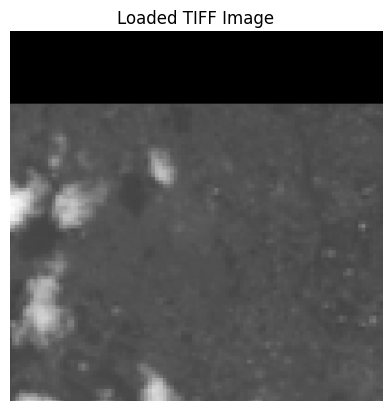

In [26]:
import rasterio
from PIL import Image
import matplotlib.pyplot as plt
def display_image(image_path):
    try:
        # Load the TIFF image using rasterio
        print("image...")
        with rasterio.open(image_path) as src:
            image = src.read(1)

        # Print image details
        print(f"Image shape: {image.shape}")
        print(f"Image dtype: {image.dtype}")

        # Display the image using matplotlib
        plt.imshow(image, cmap='gray')
        plt.title('Loaded TIFF Image')
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error loading image: {e}")

# Example usage
if __name__ == "__main__":
    #image_path = 'sentinel_image.tif'  # Replace with your TIFF image path
    image_path = '/content/drive/MyDrive/sentinel2_images/sentinel_image (3).tif'
    display_image(image_path)


To access files from your Google Drive in Google Colab, you need to mount your Drive. Run the following cell and follow the instructions to authorize Colab to access your Google Drive.

In [16]:
import rasterio
import cv2
import numpy as np

# Load GeoTIFF (assumes 3 bands: R, G, B)
with rasterio.open("/content/drive/MyDrive/sentinel2_images/sentinel_image.tif") as src:
    image = src.read([1, 2, 3])  # Read R, G, B bands

# Reshape and normalize for display/export
image = np.transpose(image, (1, 2, 0))  # CHW → HWC
image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Save as JPG
cv2.imwrite("/content/drive/MyDrive/sentinel2_images/sentinel_image (3).jpg", image)

# Save as PNG
cv2.imwrite("/content/drive/MyDrive/sentinel2_images/sentinel_image (3).png", image)

True

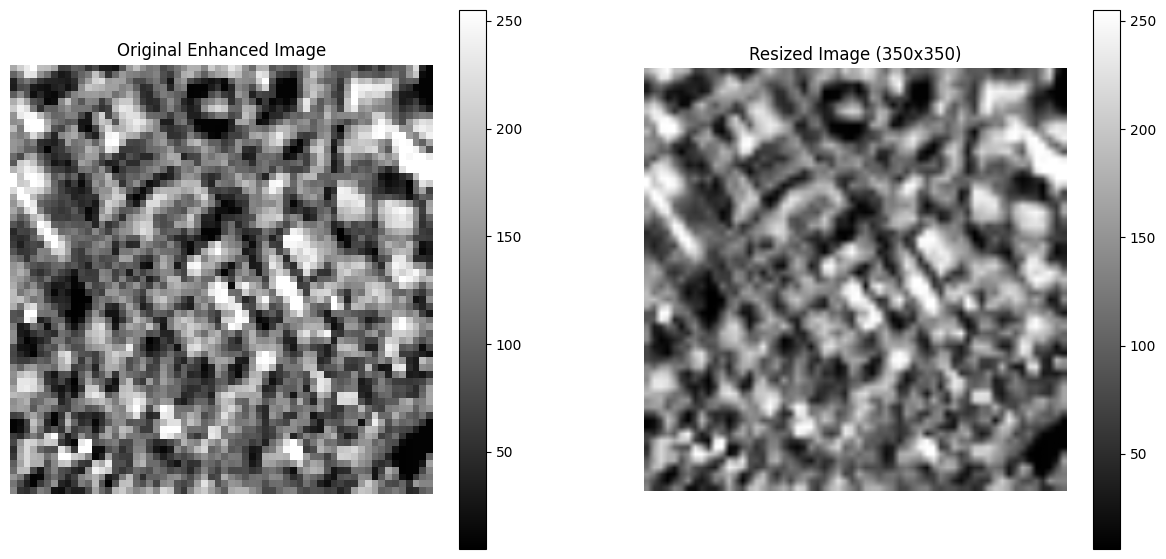

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib import patches
import rasterio

def load_preprocess_display_image(image_path):
    try:
        with rasterio.open(image_path) as src:
            image = src.read(1)

        p2, p98 = np.percentile(image, (2, 98))
        image_stretched = np.clip((image - p2) / (p98 - p2), 0, 1)

        image_8bit = np.uint8(image_stretched * 255)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image_clahe = clahe.apply(image_8bit)

        image_resized = cv2.resize(image_clahe, (350, 350))

        plt.figure(figsize=(15, 7))
        plt.subplot(1, 2, 1)
        plt.imshow(image_clahe, cmap='gray')
        plt.title('Original Enhanced Image')
        plt.axis('off')
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.imshow(image_resized, cmap='gray')
        plt.title('Resized Image (350x350)')
        plt.axis('off')
        plt.colorbar()

        plt.show()

        return image_resized

    except Exception as e:
        print(f"Error loading image: {e}")
        return None

# Example usage
image_path = '/content/drive/MyDrive/sentinel2_images/sentinel_image (3).jpg'
image_resized = load_preprocess_display_image(image_path)

Build Undirected Graphical Model

In [18]:
import networkx as nx

def undirected_graphical_model(image_resized):
    try:
        # Convert the image to grayscale if necessary
        if len(image_resized.shape) > 2 and image_resized.shape[2] == 3:
            image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
        else:
            image_gray = image_resized  # Assuming it's already grayscale

        # Create a graph using networkx
        G = nx.Graph()

        # Add nodes for each pixel
        for i in range(image_gray.shape[0]):
            for j in range(image_gray.shape[1]):
                G.add_node((i, j))

        # Add edges between neighboring pixels
        for i in range(image_gray.shape[0]):
            for j in range(image_gray.shape[1]):
                if i > 0:
                    G.add_edge((i, j), (i - 1, j))  # Connect to the pixel above
                if j > 0:
                    G.add_edge((i, j), (i, j - 1))  # Connect to the pixel to the left

        return G

    except Exception as e:
        print(f"Error creating undirected graphical model: {e}")
        return None

# Create the undirected graphical model
G = undirected_graphical_model(image_resized)
if G is not None:
    print("Undirected Graphical Model created successfully.")

Undirected Graphical Model created successfully.


In [19]:
# detect green areas

def detect_green_areas(image_resized):
    try:
        # Convert the image to grayscale if necessary
        if len(image_resized.shape) > 2 and image_resized.shape[2] == 3:
            image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
        else:
            image_gray = image_resized  # Assuming it's already grayscale

        # Detect green areas based on intensity or other criteria
        green_mask = np.zeros_like(image_gray, dtype=np.uint8)

        # Example criteria: Greenish pixels (you can adjust these thresholds)
        greenish_pixels = (image_gray >= 100) & (image_gray <= 150)
        green_mask[greenish_pixels] = 255

        return green_mask

    except Exception as e:
        print(f"Error detecting green areas: {e}")
        return None

# Detect green areas
green_mask = detect_green_areas(image_resized)

In [20]:
def perform_segmentation(G, grassy_mask):
    try:
        G.add_node("source")
        G.add_node("sink")

        rows, cols = grassy_mask.shape
        for r in range(rows):
            for c in range(cols):
                if grassy_mask[r, c]:
                    G.add_edge((r, c), "sink", capacity=1e9)
                else:
                    G.add_edge("source", (r, c), capacity=1e9)

        flow_value, flow_dict = nx.maximum_flow(G, "source", "sink")

        segmented_image = np.zeros_like(grassy_mask, dtype=np.uint8)
        for (r, c) in flow_dict["source"]:
            if isinstance(r, int) and isinstance(c, int) and r < segmented_image.shape[0] and c < segmented_image.shape[1]:
                segmented_image[r, c] = 255

        return segmented_image

    except Exception as e:
        print(f"Error performing segmentation: {e}")
        return None

# Perform segmentation
segmented_image = perform_segmentation(G, green_mask)

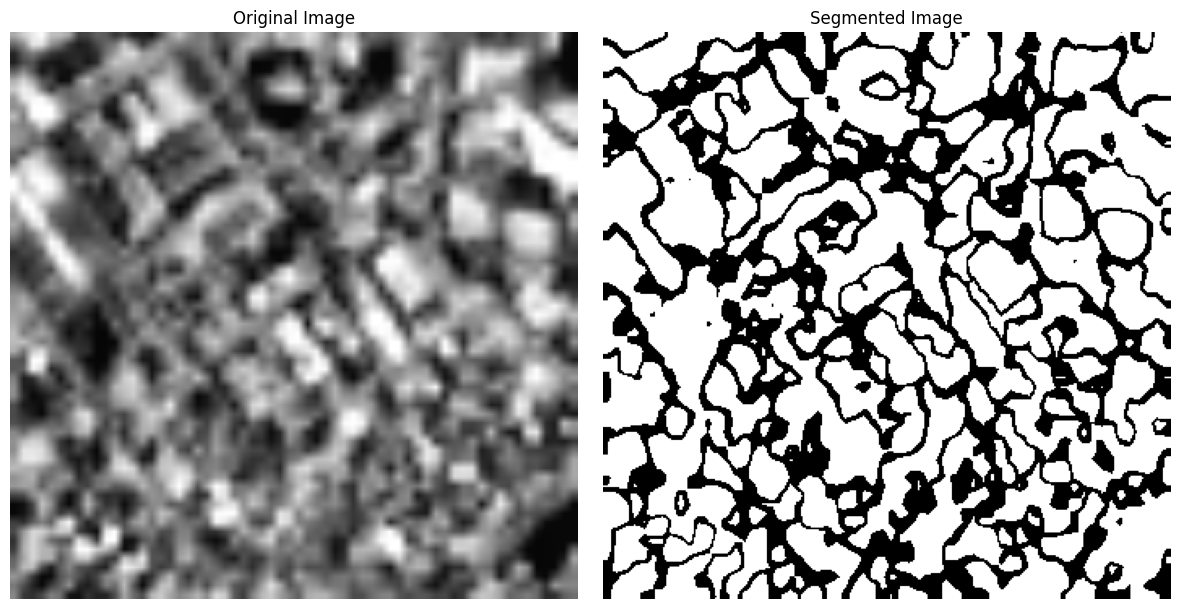

In [21]:
# Define a function to visualize the segmented image
def visualize_segmentation(image, segmented_image):
    try:
        # Create a figure with two subplots: original and segmented image
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Display the original image
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image')
        ax1.axis('off')

        # Display the segmented image
        ax2.imshow(segmented_image, cmap='gray')
        ax2.set_title('Segmented Image')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error visualizing segmentation: {e}")

# Visualize the segmented image
visualize_segmentation(image_resized, segmented_image)

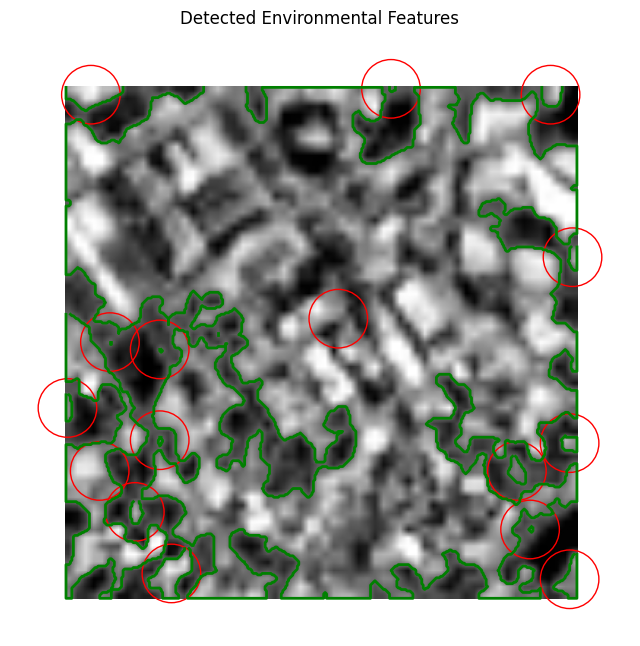

In [22]:
# Environmental features
def detect_environmental_features(image_resized):
    try:
        if len(image_resized.shape) > 2 and image_resized.shape[2] == 3:
            image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
        else:
            image_gray = image_resized

        threshold_value = 100
        binary_image = image_gray > threshold_value
        contours, _ = cv2.findContours(np.uint8(binary_image), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        plt.figure(figsize=(8, 8))
        plt.imshow(image_gray, cmap='gray')
        plt.title('Detected Environmental Features')
        plt.axis('off')

        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                plt.gca().add_patch(patches.Circle((cx, cy), radius=20, color='red', fill=False))

            plt.plot(contour[:, 0, 0], contour[:, 0, 1], 'g-', linewidth=2)

        plt.show()
        return contours

    except Exception as e:
        print(f"Error detecting environmental features: {e}")
        return None

# Example usage
contours = detect_environmental_features(image_resized)

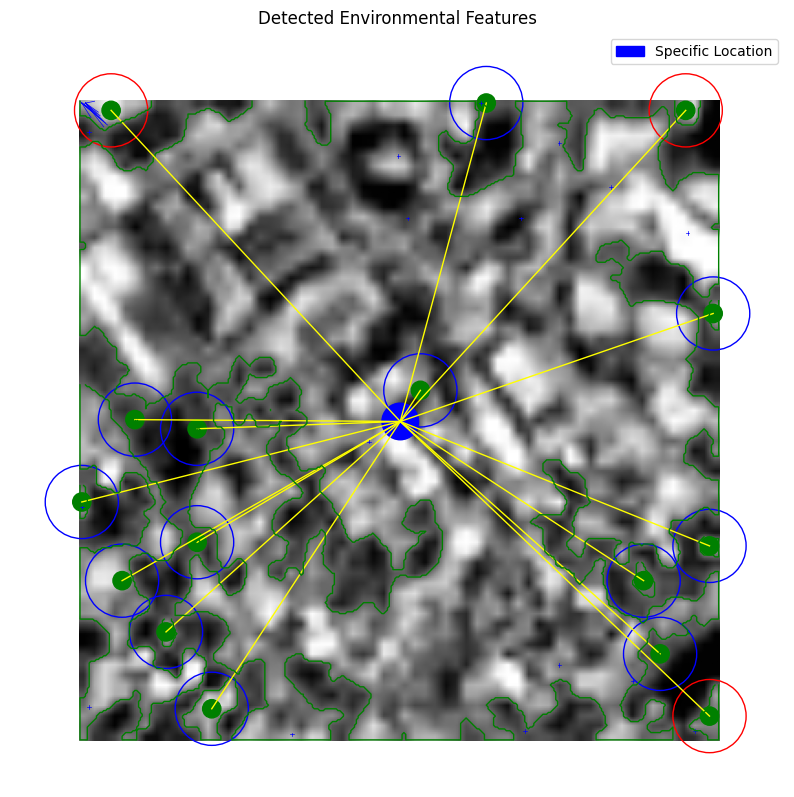

In [23]:
# Visualization
def visualize_green_areas(image_gray, contours, G, location=(175, 175)):
    try:
        plt.figure(figsize=(10, 10))
        plt.imshow(image_gray, cmap='gray')
        plt.title('Detected Environmental Features')
        plt.axis('off')

        center_x, center_y = location
        plt.gca().add_patch(patches.Circle((center_x, center_y), radius=10, color='blue', fill=True, label='Specific Location'))
        plt.legend()

        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                plt.gca().add_patch(patches.Circle((cx, cy), radius=5, color='green', fill=True))

                plt.plot([center_x, cx], [center_y, cy], 'yellow', linewidth=1)

                distance = np.sqrt((center_x - cx) ** 2 + (center_y - cy) ** 2)

                if distance <= 200:
                    circle_color = 'blue'
                elif distance <= 1000:
                    circle_color = 'red'
                else:
                    circle_color = 'yellow'

                plt.gca().add_patch(patches.Circle((cx, cy), radius=20, color=circle_color, fill=False))

                for edge in G.edges((cx, cy)):
                    plt.plot([edge[0][1], edge[1][1]], [edge[0][0], edge[1][0]], 'blue', linewidth=0.5)

            plt.plot(contour[:, 0, 0], contour[:, 0, 1], 'g-', linewidth=1)

        plt.show()

    except Exception as e:
        print(f"Error visualizing green areas: {e}")

# Example usage
visualize_green_areas(image_resized, contours, G, location=(175, 175))

✅ Image saved to green_area_map.png


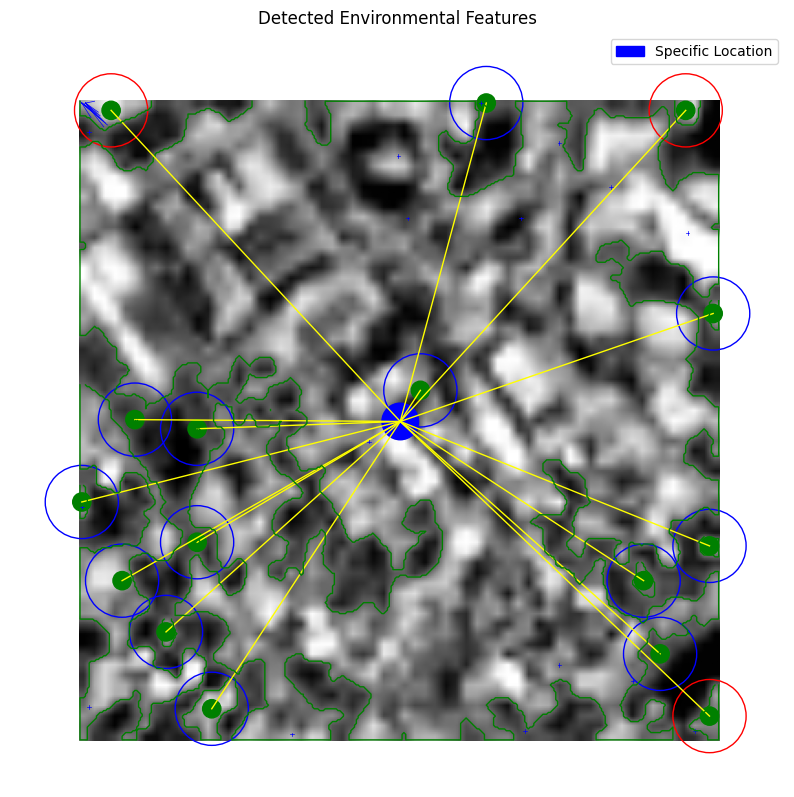

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2

def visualize_green_areas(image_gray, contours, G, location=(175, 175), save_path=None):
    try:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(image_gray, cmap='gray')
        ax.set_title('Detected Environmental Features')
        ax.axis('off')

        center_x, center_y = location
        ax.add_patch(patches.Circle((center_x, center_y), radius=10, color='blue', fill=True, label='Specific Location'))
        ax.legend()

        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                ax.add_patch(patches.Circle((cx, cy), radius=5, color='green', fill=True))

                ax.plot([center_x, cx], [center_y, cy], 'yellow', linewidth=1)

                distance = np.sqrt((center_x - cx) ** 2 + (center_y - cy) ** 2)
                if distance <= 200:
                    circle_color = 'blue'
                elif distance <= 1000:
                    circle_color = 'red'
                else:
                    circle_color = 'yellow'

                ax.add_patch(patches.Circle((cx, cy), radius=20, color=circle_color, fill=False))

                for edge in G.edges((cx, cy)):
                    ax.plot([edge[0][1], edge[1][1]], [edge[0][0], edge[1][0]], 'blue', linewidth=0.5)

            ax.plot(contour[:, 0, 0], contour[:, 0, 1], 'g-', linewidth=1)

        # Save if path is provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            print(f"✅ Image saved to {save_path}")

        plt.show()

    except Exception as e:
        print(f"Error visualizing green areas: {e}")
visualize_green_areas(image_resized, contours, G, location=(175, 175), save_path="green_area_map.png")


In [34]:
def save_green_area_mask(image_shape, contours, save_path="green_area_mask.png"):
    try:
        mask = np.zeros(image_shape, dtype=np.uint8)

        # Fill all green-area contours
        for contour in contours:
            cv2.drawContours(mask, [contour], -1, color=255, thickness=-1)  # white fill

        # Save mask image
        cv2.imwrite(save_path, mask)
        print(f"✅ Green area mask saved to {save_path}")

    except Exception as e:
        print(f"Error saving green area mask: {e}")
save_green_area_mask(image_resized.shape[:2], contours, save_path="sample_forest_mask.png")


✅ Green area mask saved to sample_forest_mask.png


NameError: name 'sample_mask' is not defined

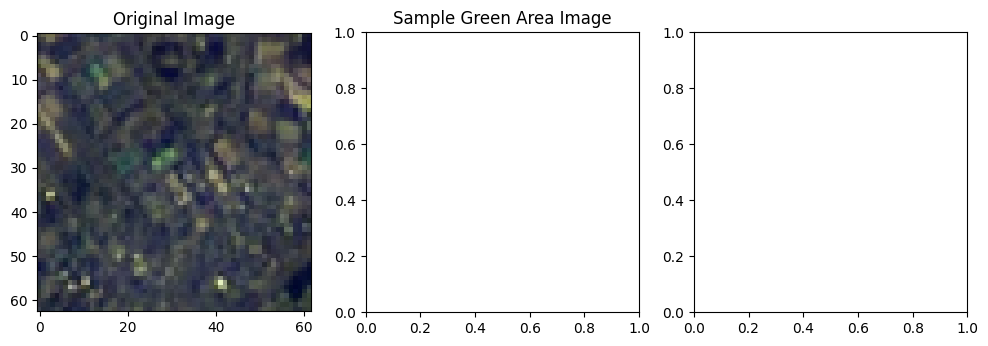

In [37]:
# Paths to original and segmented images
original_image_path = r'/content/drive/MyDrive/sentinel2_images/sentinel_image (3).jpg'
segmented_image_path = r'./sample_forest_mask.png'
# sample_green_area_path = r'Images\Forest.PNG'

# Load original and segmented images
original_image = cv2.imread(original_image_path)
segmented_image = cv2.imread(segmented_image_path)

# # Load sample green area image with error handling
# sample_green_area = cv2.imread(sample_green_area_path)
# if sample_green_area is None:
#     raise FileNotFoundError(f"Sample green area image not found at {sample_green_area_path}")

# # Resize sample green area image to match original image dimensions
# sample_green_area_resized = cv2.resize(sample_green_area, (original_image.shape[1], original_image.shape[0]))

# # Convert sample green area image to grayscale
# sample_green_area_gray = cv2.cvtColor(sample_green_area_resized, cv2.COLOR_BGR2GRAY)

# # Threshold sample green area image to create a binary mask
# _, sample_mask = cv2.threshold(sample_green_area_gray, 50, 255, cv2.THRESH_BINARY)

# Convert original and segmented images to grayscale
original_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
segmented_gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to create binary masks
_, original_mask = cv2.threshold(original_gray, 50, 255, cv2.THRESH_BINARY)
segmented_mask_resized = cv2.resize(segmented_gray, (original_mask.shape[1], original_mask.shape[0]))
_, segmented_mask = cv2.threshold(segmented_mask_resized, 50, 255, cv2.THRESH_BINARY)

# Calculate Intersection over Union (IoU)
intersection = np.logical_and(original_mask, segmented_mask)
union = np.logical_or(original_mask, segmented_mask)
iou = np.sum(intersection) / np.sum(union)

# Calculate Precision, Recall, and F1 Score
true_positive = np.sum(np.logical_and(original_mask, segmented_mask))
false_positive = np.sum(np.logical_and(np.logical_not(original_mask), segmented_mask))
false_negative = np.sum(np.logical_and(original_mask, np.logical_not(segmented_mask)))

precision = true_positive / (true_positive + false_positive + 1e-6)  # Adding a small epsilon to avoid division by zero
recall = true_positive / (true_positive + false_negative + 1e-6)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

# Display results
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(2, 3, 2)
# plt.imshow(cv2.cvtColor(sample_green_area_resized, cv2.COLOR_BGR2RGB))
plt.title('Sample Green Area Image')

plt.subplot(2, 3, 3)
plt.imshow(sample_mask, cmap='gray')
plt.title('Sample Mask')

plt.subplot(2, 3, 4)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image')

plt.subplot(2, 3, 5)
plt.imshow(segmented_mask, cmap='gray')
plt.title('Segmented Mask')

plt.subplot(2, 3, 6)
plt.imshow(intersection, cmap='gray')
plt.title('Intersection (IoU)')

plt.tight_layout()
plt.show()

print(f"IoU: {iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

After mounting your Drive, the image file should be located at a path like `/content/drive/My Drive/sentinel2_images/sentinel_image.tif`. You can then update the `image_path` variable in the code to this new path.